# Burlington Property Analysis
### Yujia Zhang, Ya Tuo

[Jump to Data Analysis Section](#Analysis)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator
import scipy.stats as stats
import seaborn as sns
from geopy.distance import vincenty

## Functions

In [2]:
def closest(pt, dic):
    """Find the closest park, and find the distance to the closest park
    :para   pt: property location, e.g.(longtitude, latitude)
          dict: a dictionary that is consisted of the name of each park and their corresponding coordinates,
                e.g.{"the name of park": "(latitute, longtitude)"}
    :return     shortest: the distance between the property and its closest park
            dic[shortestKey]: the name of the closest park
    """
    locations = list(dic.keys())
    distance = list(map(lambda i: get_distance(pt, i), locations))
    shortest = min(distance)
    shortestIndex = distance.index(shortest)
    shortestKey = locations[shortestIndex]
    return shortest, dic[shortestKey]

def convertCoordToFloatTuple(coordinate):
    """Connvert string coordinate to a tuple of float numbers
    :para     coordinate: the original string coordinate
    :return   newCoord: a tuple of float numbers
    """
    try:
        coord = coordinate[1:-1].replace(" ", "").split(',')
        newCoord = tuple(map(float, coord)) 
        return newCoord
    except:
        return coordinate 

def convert_cost_to_float(df):
    """Convert the cost to float numbers
    :para   df: the original dataframe
    :return df: the dataframe with cost as float numbers
    """
    df["ProjectCost"] = df["ProjectCost"].astype('float')
    return df

def convert_coordinate(df):
    """Convert coordinates to a tuple of floats
    :para   df: the original datafram
    :return df: the new dataframe with coordinates as a tuple of floats
    """
    try:
        return df.apply(lambda x: convertCoordToFloatTuple(x))
    except:
        return df
    
def calculate_distance(coord1, coord2):
    """Calculate the distance between two coordinates
    :para   coord1: coordinate of the property
            coord2: coordinate of the park
    :return dist: the distance between the property and the park
    """
    dist = vincenty(coord1, coord2).km
    return dist

def classifyGrade(df1):
    """ In the original dataframe, there are 21 levels for the variable "Grade",
        for better visualization, this function will combine some of them
        and return a new dataframe with 7 levels for "Grade"
    
    :para df1: the original dataframe
    
    :return df1: the new datafram with Grade re-classified 
    """
    for index,row in df1.iterrows():
        if row['Grade'] in ('AVERAGE','AVERAGE PLUS','AVERAGEMINUS'):
            df1.set_value(index,'Grade','Average')
        
        elif row['Grade'] in ('CUSTOM', 'CUSTOM MINUS','CUSTOM PLUS'):
            df1.set_value(index,'Grade','Custom')
        
        elif row['Grade'] in ('EXCELLENT','EXCLNT MINUS','EXCLT PLUS'):
            df1.set_value(index,'Grade','Excellent')
    
        elif row['Grade'] in ('FAIR','FAIR MINUS','FAIR PLUS'):
            df1.set_value(index,'Grade','Fair')
        
        elif row['Grade'] in ('GOOD','GOOD MINUS','GOOD PLUS'):
            df1.set_value(index,'Grade','Good')
            
        elif row['Grade'] in ('POOR','POOR MINUS','POOR PLUS'):
            df1.set_value(index,'Grade','Poor')
        
        elif row['Grade'] in ('VERY GOOD','VRYGOODMINUS','VRYGOODPLUS'):
            df1.set_value(index,'Grade','Very Good')
    return df1

def drop_the_index(df):
    """ Drop the index column the the dataframe
    :para   df: the original datafram
    :return     the new dataframe without the index column
    """
    try:
        return dfPark.reset_index(drop=True)
    except:
        return df

def drop_column(df,var):
    """Drop a specific column
    :para   df: the original dataframe
            var: the column that needs to be dropped
    :return      the new dataframe without that column
    """
    try:
        return df.drop(var, axis=1)
    except:
        return df

def drop_missing_values(df):
    """Drop missing values in a dataframe
    :para   df: the original dataframe
    :return     the new dataframe without missing values
    """
    df.dropna(axis=0, inplace=True)
    return df

def drop_zero_negative_values(df):
    """Drop zero and negative values in a dataframe
    :para   df: the original dataframe
    :return df: the new dataframe without zero and negative values
    """
    df = df[(df > 0).all(1)]
    return df

def find_closest_park(propertyCoordinate, parkName2ListOfCoord):
    """Find the closest park and the shortest distance to the closest park for each property
    :para   propertyCoordinate: the coordinate of the property
            parkName2ListofCoord: a dictionary of all parks and their coordinates
    :return shortestDistanceToParks: the distance to the closest park
            closestParkName: the name of the closest park
    """
    tempDistanceToPark = 1000000
    closestParkName = None
    for park in parkName2ListOfCoord.keys():
        listOfParkCoord = parkName2ListOfCoord[park]
        shortestDistanceToThatPark = find_shortest_distance_to_each_park(propertyCoordinate, listOfParkCoord)
        shortestDistanceToParks = find_shorter_distance(tempDistanceToPark, shortestDistanceToThatPark)
        if shortestDistanceToParks != tempDistanceToPark: # DID find a closer park
            closestParkName = park
        tempDistanceToPark = update_tempDistance(shortestDistanceToParks)

    return shortestDistanceToParks, closestParkName

def find_shortest_distance_to_each_park(propertyCoordinate, listOfParkCoords):
    """Find the shortest distance to each park (some parks have multiple coordinates)
    :para   propertyCoordinate: the coordinate of the property
            listOfParkCoords: a list of coordinates of parks
    :return shortestDistance: the shortest distance to each park for that property
    """
    lonProperty = propertyCoordinate[0]
    latProperty = propertyCoordinate[1]
    coordProperty = (latProperty, lonProperty)
    
    tempDistance = 100000
    for parkCoord in listOfParkCoords:
        lonPark = parkCoord[1]
        latPark = parkCoord[0]
        coordPark = (latPark, lonPark)
        distance = calculate_distance(coordProperty, coordPark)
        shortestDistance = find_shorter_distance(tempDistance, distance)
        tempDistance = update_tempDistance(shortestDistance)
    return shortestDistance

def find_shorter_distance(temp, distance):
    """Find the shorter distance
    :para   temp: the current "shortest" distance
            distance: the newly calculated distance
    :return temp: if the current shortest distance is shorter
            distance: if the newly calculated distance is shorter
    """
    if temp <= distance:
        return temp
    else:
        return distance
    
def group_by_levels(var, listOfLevels):
    """Create a dictionary with different levels of a variable as keys, and a list of values of each level
        as values respectively
    :para   var: the variable/column name of the dataframe
            listOfLevels: a sorted list of levels for that variable (sorted by median value)
    :return sd2: a dictionary with levels as keys and a list of value of each levels as values
    """
    df = dfPropertyClean[[var,'CurrentBuildingValue']]
    dfVarValue = df.groupby(var)['CurrentBuildingValue'].apply(lambda x: x.tolist())
    sd = dfVarValue.to_dict()
    sd2 = {x: sd[x] for x in listOfLevels}
    return sd2

def get_distance(loc1, loc2): 
    """Description
    :para loc1: the location of the property (longtitude, latitude)
          loc2: the location of the park (latitude, lontitude)
    :return dist: the distance between the property and the park
    """
    lon1 = loc1[0]
    lat1 = loc1[1]
    lon2 = loc2[1]
    lat2 = loc2[0]
    
    coord1 = (lat1, lon1)
    coord2 = (lat2, lon2)
    dist = vincenty(coord1, coord2).km
    return dist

def make_a_copy(df):
    """Make a copy of the original dataframe
    :para   df: the original datafram
    :return     a copy of that dataframe
    """
    return df.copy()

def read_df_from_csv(path):
    """Read the dataframe from a .csv file
    :para   path: the path of the .csv file
    :return df: the dataframe read from the .csv file
    """
    df = pd.read_csv(path)
    return df

def remove_dollar_sign(df,var):
    """Remove the dollar sign in the "Project Cost" column in dataframe "dfParkClean"
    :para   df: the dataframe
            var: the column name
    :return newDf: the new dataframe without the dollar sign in the specific column
    """
    tempList = list(df[var])
    tempListNew = [x[1:] for x in tempList]
    df['ProjectCost'] = pd.Series(tempListNew)
    newDf = df.drop([var], axis=1)
    return newDf

def sort_by_median(var, listOfLevels):
    """For a column/variable in a dataframe, sort different levels of that variable by the median values 
        with respect to different levels
    :para   var: the column name/variable
            listOfLevels: a list of different levels for that variable
    :return levelsSorted2: a list of sorted levels
    """
    df = dfPropertyClean[[var,'CurrentBuildingValue']]
    cc = df.groupby(var).median().sort_values(by=['CurrentBuildingValue'])
    levelsSorted = cc.index.values
    levelsSorted2 = [x for x in levelsSorted if x in listOfLevels]
    
    return levelsSorted2

def top_10_frequent(var):
    """Find the top 10 levels with the highest frequencies of a variable
    :para   var: the variable/column name
    :return top10List: a list of 10 levels with highest frequencies
    """
    top10List = list(dfPropertyClean[var].value_counts()[:10].to_dict().keys()) 
    
    return top10List

def update_tempDistance(shorterDistance):
    """Update the current shortest distance
    :para   shortestDistance: shortest Distance
    :return shortestDistance: updated the current shortest Distance
    """
    return shorterDistance

---
## Data Reading

In [3]:
propertyDataPath = "City_of_Burlington_Property_Details.csv"

# Read the file into dataframe
dfProperty = read_df_from_csv(propertyDataPath)

# Keep those columns that we are interestd in
dfProperty = dfProperty[["BuildingType",
                   "Grade",
                   'LandUse',
                   "YearBlt",
                   "CurrentBuildingValue",
                   "PropertyCenterPoint"]]

# variable "Grade" has too many levels, so we re-classify it into 7 levels
dfProperty = classifyGrade(dfProperty)

In [4]:
parkDataPath = "Penny_for_Parks_Improvement_Data.csv"

# Data Reading
dfPark = read_df_from_csv(parkDataPath)
dfpark = drop_the_index(dfPark)

# Keep variables that we are interested in
dfPark = dfPark[["Project",
                 "Project_Cost",
                 "Location",
                 "Location_1"]]

## Data Cleaning

In [5]:
# Data Cleaning
dfPropertyClean = make_a_copy(dfProperty)
#dfPropertyClean["YearBlt"] = df_property_clean["YearBlt"].astype('str') 

# Drop rows that contain any missing value
dfPropertyClean = drop_missing_values(dfPropertyClean)
dfPropertyClean = drop_zero_negative_values(dfPropertyClean)

dfPropertyClean['PropertyCenterPoint'] = convert_coordinate(dfProperty['PropertyCenterPoint'])

In [6]:
# Data Cleaning
# Drop rows that contain any missing values
dfParkClean = make_a_copy(dfPark)
dfParkClean = drop_missing_values(dfParkClean)
dfParkClean = remove_dollar_sign(dfParkClean,'Project_Cost')
dfParkClean = convert_cost_to_float(dfParkClean)

## Data Computing

In [7]:
dfParkClean['Coordinate'] = convert_coordinate(dfParkClean['Location_1'])
dfParkClean = drop_column(dfParkClean, ['Location_1'])
#dfParkClean['Location_1'].apply(lambda x: convertCoordToFloatTuple(x))

cc = dfParkClean.groupby('Location')['Coordinate'].apply(lambda x: x.tolist())
park2location = cc.to_dict()

In [8]:
# for each property, calculate its distance to each park, save the shortest distance and the name of the closest park
# dfPropertyClean, shortest distance, the name of the closest park
for index,row in dfPropertyClean.iterrows():
    propertyCoord = row["PropertyCenterPoint"]
    shortestDistance, park = find_closest_park(propertyCoord, park2location)
    dfPropertyClean.set_value(index,'ShortestDistance',shortestDistance)
    dfPropertyClean.set_value(index,'ClosestPark',park)

## Data Transformation

In [9]:
originalValue = dfPropertyClean['CurrentBuildingValue'].tolist()
originalDistance = dfPropertyClean['ShortestDistance'].tolist()

transformedValue, _ = stats.boxcox(originalValue)
transformedDistance, _ = stats.boxcox(originalDistance)

dfPropertyClean['TransformedValue'] = pd.Series(transformedValue)
dfPropertyClean['TransformedDistance'] = pd.Series(transformedDistance)

## Data Showing

In [10]:
dfPropertyClean[:3]

,BuildingType,Grade,LandUse,YearBlt,CurrentBuildingValue,PropertyCenterPoint,ShortestDistance,ClosestPark,TransformedValue,TransformedDistance
0,OLD STYLE,Average,Exempt,1890,170700.0,"(-73.1993, 44.48146)",0.718134,Pomeroy Park,12.529168,-0.313775
1,RANCH,Average,Single Family,1950,88200.0,"(-73.2126, 44.4648)",0.283407,Calahan Park,11.816914,-1.032907
2,OFFICE GENR,Average,Commercial,1899,1145100.0,"(-73.2143, 44.47423)",0.261739,City Hall Park,14.599357,-1.084850


In [11]:
dfParkClean[:3]

,Project,Location,ProjectCost,Coordinate
0,Barge Canal Paving,Barge Canal,38500.0,"(44.46909, -73.21894)"
1,Blanchard Beach Bridge Non-slip Surfacing,Oakledge Park/Blanchard Beach,10768.0,"(44.45806, -73.22242)"
2,Lakeside Park Basketball Court Resurfacing,Lakeside Park,31849.0,"(44.45969, -73.22)"


---
# Analysis

## How the grade of building will affect the building's value?

In [12]:
dfPropertyClean['CurrentBuildingValue'].describe()

count    1.022200e+04
mean     3.238400e+05
std      3.800667e+06
min      1.000000e+02
25%      1.180000e+05
50%      1.501000e+05
75%      2.165000e+05
max      3.671132e+08
Name: CurrentBuildingValue, dtype: float64

In [13]:
valueMed = dfPropertyClean['CurrentBuildingValue'].median()

In [14]:
dfPropertyClean['Grade'].describe()

count       10222
unique          7
top       Average
freq         5389
Name: Grade, dtype: object

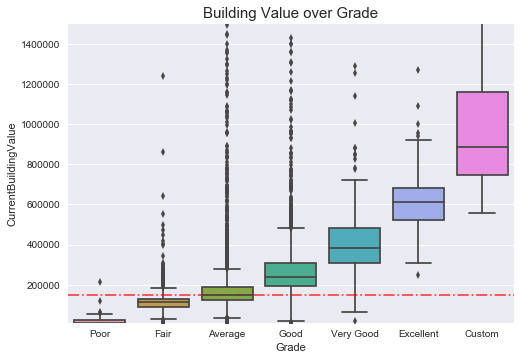

In [15]:
listOfGrades = list(set(dfPropertyClean['Grade'].tolist()))
sortedGrade = sort_by_median('Grade', listOfGrades)

sns.boxplot(x='Grade', y='CurrentBuildingValue',
            data=dfPropertyClean, order=sortedGrade)
plt.ylim(ymax = 1500000, ymin = 10000)
plt.axhline(y=valueMed, color='r', linestyle='-.', alpha=0.7)
plt.title('Building Value over Grade', fontsize=15)
plt.show()

In [16]:
ww = dfPropertyClean.groupby('Grade')['CurrentBuildingValue'].apply(list)
# Kruskal-Wallis Test
stat, pValue = stats.kruskal(*ww)
print(stat, pValue)

4290.67856133 0.0


## How the type of building will affect the building's value?

In [17]:
dfPropertyClean['BuildingType'].describe()

count         10222
unique          118
top       OLD STYLE
freq           2169
Name: BuildingType, dtype: object

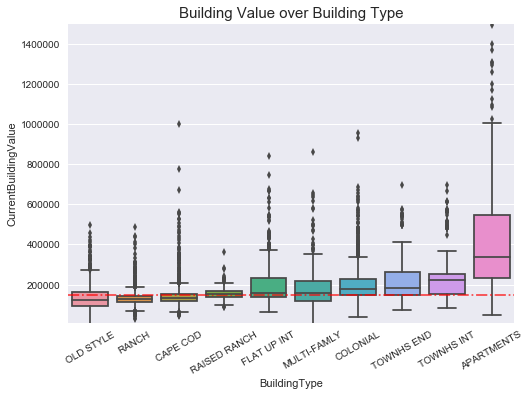

In [18]:
top10Type = top_10_frequent('BuildingType')
sortedType = sort_by_median('BuildingType', top10Type)

sns.boxplot(x='BuildingType', y='CurrentBuildingValue',
            data=dfPropertyClean, order=sortedType)
plt.ylim(ymax = 1500000, ymin = 10000)
plt.xticks(rotation=30)
plt.axhline(y=valueMed, color='r', linestyle='-.', alpha=0.7)
plt.title('Building Value over Building Type', fontsize=15)
plt.show()

In [19]:
ww = dfPropertyClean.groupby('BuildingType')['CurrentBuildingValue'].apply(list)
# Kruskal-Wallis H-test
stat, pValue = stats.kruskal(*ww)
print(stat, pValue)

3883.36311763 0.0


## How the land use of building will affect the building's value?

In [20]:
dfPropertyClean['LandUse'].describe()# landuse

count             10222
unique               22
top       Single Family
freq               5156
Name: LandUse, dtype: object

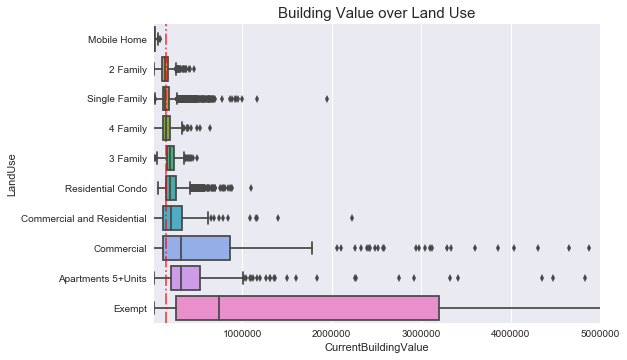

In [21]:
top10LandUse = top_10_frequent('LandUse')
sortedLandUse = sort_by_median('LandUse', top10LandUse)

sns.boxplot(y='LandUse', x='CurrentBuildingValue',
            data=dfPropertyClean, order=sortedLandUse,
           orient='h')
plt.xlim(xmax = 5000000, xmin = 10000)
plt.axvline(x=valueMed, color='r', linestyle='-.', alpha=0.7)
plt.title('Building Value over Land Use', fontsize=15)
plt.show()

In [22]:
ww = dfPropertyClean.groupby('LandUse')['CurrentBuildingValue'].apply(list)
# Kruskal-Wallis H-test
stat, pValue = stats.kruskal(*ww)
print(stat, pValue)

2272.83138138 0.0


## How the year of building will affect the building's value?

In [23]:
dfPropertyClean['YearBlt'].describe()

count    10222.000000
mean      1945.210526
std         36.478445
min       1798.000000
25%       1910.000000
50%       1951.000000
75%       1975.000000
max       2015.000000
Name: YearBlt, dtype: float64

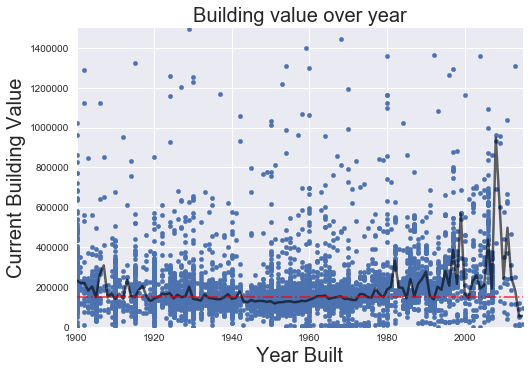

In [24]:
q = 'YearBlt >= 1900'
dfPropertyClean.query(q).plot(x='YearBlt', 
                              y='CurrentBuildingValue',
                              kind='scatter')
dfPropertyClean.query(q).groupby('YearBlt')['CurrentBuildingValue'].median().plot(color='k',
                                                                                  alpha=0.6,
                                                                                  linewidth=2.5)
plt.ylim(ymax = 1500000, ymin = 1000)
plt.axhline(y=valueMed, color='r', linestyle='-.', alpha=0.7)
plt.title('Building value over year', fontsize = 20)
plt.xlabel("Year Built", fontsize = 20)
plt.ylabel("Current Building Value", fontsize = 20)
plt.show()

## How the distance to the closest park will affect the building's value?

In [25]:
dfPropertyClean['ShortestDistance'].describe()

count    10222.000000
mean         0.507666
std          0.301734
min          0.011351
25%          0.280275
50%          0.436803
75%          0.711551
max          1.940608
Name: ShortestDistance, dtype: float64

In [26]:
distMedian = dfPropertyClean['ShortestDistance'].median()

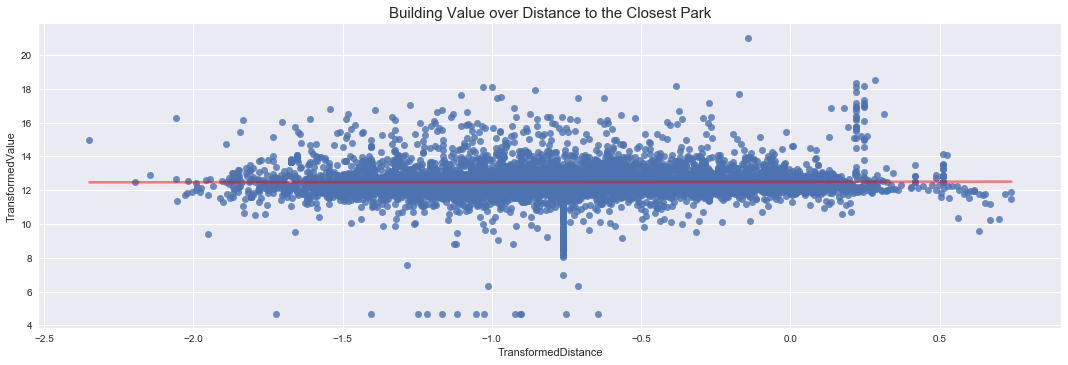

In [27]:
sns.lmplot(x='TransformedDistance', y='TransformedValue',
           data=dfPropertyClean, aspect=3, line_kws={'color': 'red', 'alpha':0.4},
          truncate=True)
plt.title('Building Value over Distance to the Closest Park', fontsize=15)
plt.show()

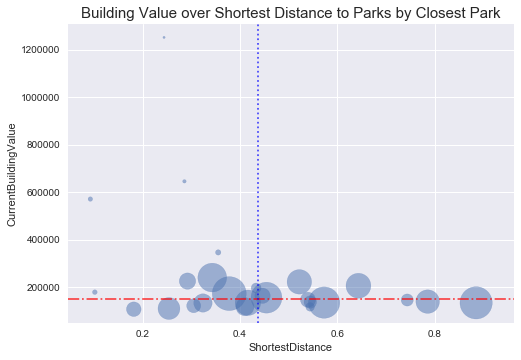

In [28]:
ww = dfPropertyClean.groupby('ClosestPark').agg({'CurrentBuildingValue': 'median',
                                               'ShortestDistance':'median',
                                               'BuildingType':'count'})
ww.plot(kind='scatter', x='ShortestDistance', y='CurrentBuildingValue',
        alpha=0.5, s=ww.BuildingType)
plt.axhline(y=valueMed, color='r', linestyle='-.', alpha=0.7)
plt.axvline(x=distMedian, color='b', linestyle=':', alpha=0.7)
plt.title('Building Value over Shortest Distance to Parks by Closest Park', fontsize=15)
plt.show()

## How the improvement cost on each park will affect the building's value nearby?

In [29]:
dfParkClean['ProjectCost'].describe()

count        61.000000
mean      20466.131148
std       36390.295068
min         224.000000
25%        3172.000000
50%        7034.000000
75%       14850.000000
max      193540.000000
Name: ProjectCost, dtype: float64

In [30]:
dfParkClean = drop_missing_values(dfParkClean)

In [31]:
# Calculate the total improvement cost for each park
park2cost = dfParkClean[['Location','ProjectCost']].groupby('Location').sum()
park2value = dfPropertyClean[['ClosestPark','CurrentBuildingValue']].groupby('ClosestPark').median()
dfCostValue = park2cost.join(park2value, how='inner')

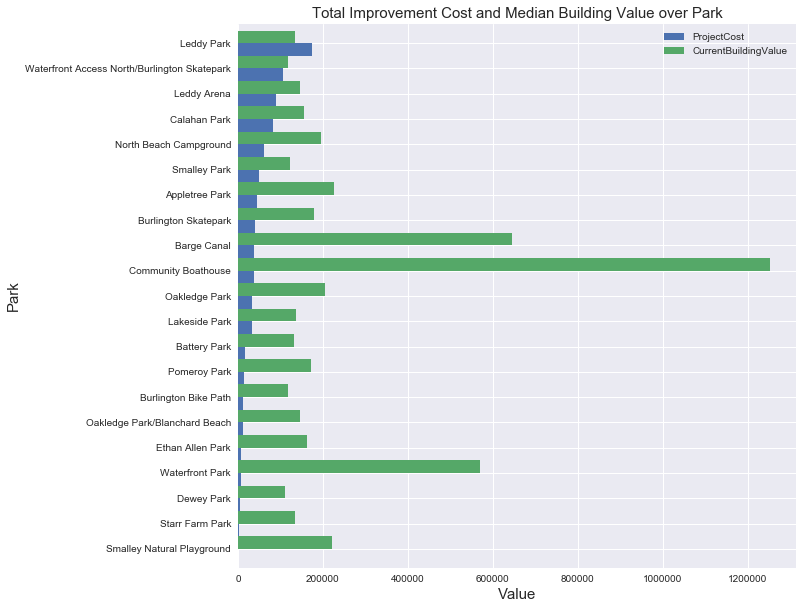

In [32]:
# barplot: total improvement cost and median building value over park
df4 = dfCostValue.sort_values(by=['ProjectCost'])

df4.plot(kind = 'barh', width = 1, figsize=(10,10))
plt.title('Total Improvement Cost and Median Building Value over Park', fontsize = 15)
plt.xlabel("Value", fontsize = 15)
plt.ylabel("Park", fontsize = 15)
plt.show()